# The Factor Model
## Factors:
#### Market:
S&P 500 returns
#### HML:
The premium of high-value (high market-to-book value ratio) over low-value stocks
#### Volume:
The amount of shares being traded. Maybe volume ratio? (i.e. volume/(total shares))

In [160]:
library(xts)
library(TTR)
library(tidyquant)
library(rvest)#for web scraping of symbols
library(magrittr) #piping
library(httr)#web scraping
library(jsonlite)#api
library(lubridate)
library(lattice)
library(timeSeries)#financial time series
library(rugarch)
library(forecast)
library(betategarch)#for EGARCH
library(mfGARCH)#multi-factor GARCH, incoporating short-term and long-term volatility
library(curl)
library(GAS)
library(dplyr)
library(zoo)

In [164]:
#tidyquant data getting
get_tq_sp500_data <- function(start, end, ...){
    tickers <- list(...)
    if(length(tickers) > 0){
        data <- tibble(symbol = tickers) %>%
                    mutate(stock.prices = map(.x = symbol, ~ tq_get(.x, get = "stock.prices", from = start, to = end)))
    } else{
        data <- tq_index("SP500") %>% tq_get(get = "stock.prices", from = start, to = end)
    }
    return(data)
}

get_daily_returns <- function(start, end, returns, ...){
    tickers <- list(...)
    if(length(tickers) > 0){
        data <- returns %>% group_by(symbol) %>% filter(symbol %in% tickers) %>% tq_transmute(select = adjusted, 
                                                           mutate_fun = periodReturn, 
                                                           period     = "daily", 
                                                           col_rename = "daily.returns") 
    } else{
        data <- returns %>% group_by(symbol) %>% tq_transmute(select = adjusted, 
                                                           mutate_fun = periodReturn, 
                                                           period     = "daily", 
                                                           col_rename = "daily.returns") 
    }
    return(data[-1,])
}

get_daily_log_returns <- function(start, end, returns){
         log_returns <- returns %>% group_by(symbol) %>% tq_transmute(select = adjusted, 
                     mutate_fun = periodReturn, 
                     type       = "log", 
                     period     = "daily",
                     col_rename = "daily.log.ret")
    return(log_returns[-1,])
}

get_price_to_book <- function(start, end, ticker, ExPriceData){
    data <- ticker %>% tq_get(get = "key.ratios", from = start, to = end)
    pricebook_annual_df <-  data %>% 
                        dplyr::filter(section == "Valuation Ratios") %>% 
                        unnest() %>%
                        dplyr::filter(category == "Price to Book")   
    abv_dates <- pricebook_annual_df$date
    #print(pricebook_annual_df$date)
    abvd_prices_df <- ExPriceData %>% 
                            group_by(symbol) %>% 
                            dplyr::filter(symbol == ticker) %>%
                            dplyr::filter(date %in% abv_dates)
    #print(abvd_prices_df$'adjusted')
    annual_book_val <- (1.0/pricebook_annual_df$value) %*% (abvd_prices_df$'adjusted')
    pricebook <- (ExPriceData %>% group_by(symbol))$'adjusted'
    for(i in 1:dim(ExPriceData)[1]){
        pricebook[i] <- pricebook[i]/annual_book_val[i]
    }
    return(pricebook)
}
sign_log_abs <- function(x){
    return( (sign(x)) * log(abs(x)))
}
ret_to_logret <- function(returns){
    log_returns <- lapply(returns, sign_log_abs)
    return(log_returns %>% as.vector() %>% na.omit())#as.vector(unlist(log_returns)))
}

In [165]:
get_simfin_id <- function(ticker){
    #format 'https://simfin.com/api/v1/info/find-id/ticker/{ticker}?api-key={api_key}'
    request_url_pt1 <- "https://simfin.com/api/v1/info/find-id/ticker/"
    request_url_pt2 <- "?api-key=Tnh5abVKzdE8Np4y7RQoO9ZFTdROoNaU"
    idstr <- paste(request_url_pt1, ticker , request_url_pt2,sep="")
    id <- fromJSON(idstr)
    id <- id$simId
    return(id)
}


get_simfin_id_vec <- function(tickers){
    id <- rep(0,length(tickers)) # store simfin ID's 
    id <- lapply(tickers, get_simfin_id)
    return(id$simId)
}
#fundamentals data through simfin

get_simfin_TTM_BookPerShare <- function(simfin_id, year = "TTM"){
    indicator <- '4-18'
    finder_url <- "https://simfin.com/api/v1/finder?api-key=Tnh5abVKzdE8Np4y7RQoO9ZFTdROoNaU"
    #'https://simfin.com/api/v1/companies/id/{sim_id}/statements/standardised?stype={statement_type}&fyear={year}&ptype={time_period}&api-key={api_key}'
    #company_data_url1 <- "https://simfin.com/api/v1/companies/id/"
    company_data_url2 <- "/ratios/?fyear="
    company_data_url3 <- "&indicators="
    company_data_url4 <- "&period=Q1,Q2,Q3,Q4"
    company_data_url5 <- "&api-key=Tnh5abVKzdE8Np4y7RQoO9ZFTdROoNaU"

    #time_len <- strtoi(end_yr) - strtoi(start_yr)
    
    #time_periods <- c("Q1","Q2","Q3","Q4")
    #for now, only get start yr data until I can see what it looks like in R
    url_tot <- paste(finder_url, simfin_id, company_data_url2,year, company_data_url3, indicator, company_data_url4,company_data_url5,sep="")
    print(url_tot)
    statement <- url_tot %>% fromJSON()
    return(statement)
}


In [240]:
#writes historical price data to OR project local repo
write_historical_price_data <- function(start, end){
    dir <- "/Users/zanejakobs/Desktop/ORProj/Data/Historical/prices_2016.csv"
    sp500data <- get_tq_sp500_data(start,end) %>% group_by(symbol)
    write.csv(sp500data, file=dir)
}
write_historical_market_data <- function(start,end){
    dir <- "/Users/zanejakobs/Desktop/ORProj/Data/Historical/market_2016.csv"
    market <- tq_get("SPY", from = start, to = end)
    write.csv(market, file=dir)
}

In [325]:
#AAPL_ID <- get_simfin_id("AAPL")
#AAPL_PB <- get_simfin_TTM_BookPerShare(AAPL_ID, "2018")
#AAPL_PB
aapl_key_ratios <- tq_get("AAPL", get = "key.ratios", period = "daily")
gkr <- aapl_key_ratios %>% 
    dplyr::filter(section == "Valuation Ratios") %>% 
    unnest() %>%
    dplyr::filter(category == "Price to Book") 
gkr

section,sub.section,group,category,date,value
Valuation Ratios,Valuation Ratios,88,Price to Book,2009-12-31,3.998731
Valuation Ratios,Valuation Ratios,88,Price to Book,2010-12-31,4.124335
Valuation Ratios,Valuation Ratios,88,Price to Book,2011-12-30,3.274984
Valuation Ratios,Valuation Ratios,88,Price to Book,2012-12-31,3.176863
Valuation Ratios,Valuation Ratios,88,Price to Book,2013-12-31,3.465282
Valuation Ratios,Valuation Ratios,88,Price to Book,2014-12-31,4.971060
Valuation Ratios,Valuation Ratios,88,Price to Book,2015-12-31,4.412521
Valuation Ratios,Valuation Ratios,88,Price to Book,2016-12-30,4.716213
Valuation Ratios,Valuation Ratios,88,Price to Book,2017-12-29,6.427213
Valuation Ratios,Valuation Ratios,88,Price to Book,2018-12-31,6.498402


In [4]:
sp2018 <- get_tq_sp500_data('2018-01-01','2018-12-31')
head(sp2018)

Getting holdings for SP500
Warning message:
“x = 'BRK.B', get = 'stock.prices': Error: BRK.B download failed after two attempts. Error message:
HTTP error 404.
 Removing BRK.B.”Warning message:
“x = 'TFCFA', get = 'stock.prices': Error: TFCFA download failed after two attempts. Error message:
HTTP error 400.
 Removing TFCFA.”Warning message:
“x = 'TFCF', get = 'stock.prices': Error: TFCF download failed after two attempts. Error message:
HTTP error 400.
 Removing TFCF.”Warning message:
“x = 'BF.B', get = 'stock.prices': Error: BF.B download failed after two attempts. Error message:
HTTP error 404.
 Removing BF.B.”

symbol,company,weight,sector,shares_held,date,open,high,low,close,volume,adjusted
MSFT,Microsoft Corporation,0.03824539,Information Technology,86246140,2018-01-02,86.13,86.31,85.50,85.95,22483800,84.12813
MSFT,Microsoft Corporation,0.03824539,Information Technology,86246140,2018-01-03,86.06,86.51,85.97,86.35,26061400,84.51965
MSFT,Microsoft Corporation,0.03824539,Information Technology,86246140,2018-01-04,86.59,87.66,86.57,87.11,21912000,85.26354
MSFT,Microsoft Corporation,0.03824539,Information Technology,86246140,2018-01-05,87.66,88.41,87.43,88.19,23407100,86.32065
MSFT,Microsoft Corporation,0.03824539,Information Technology,86246140,2018-01-08,88.20,88.58,87.60,88.28,22113000,86.40874
MSFT,Microsoft Corporation,0.03824539,Information Technology,86246140,2018-01-09,88.65,88.73,87.86,88.22,19484300,86.35001


In [324]:
#get the data!
#sp1018 <- get_tq_sp500_data('2010-01-01','2018-12-31')
head(sp1018)

symbol,company,weight,sector,shares_held,date,open,high,low,close,volume,adjusted
MSFT,Microsoft Corporation,0.03831607,Information Technology,86145210,2010-01-04,30.62,31.10,30.59,30.95,38409100,24.61580
MSFT,Microsoft Corporation,0.03831607,Information Technology,86145210,2010-01-05,30.85,31.10,30.64,30.96,49749600,24.62375
MSFT,Microsoft Corporation,0.03831607,Information Technology,86145210,2010-01-06,30.88,31.08,30.52,30.77,58182400,24.47263
MSFT,Microsoft Corporation,0.03831607,Information Technology,86145210,2010-01-07,30.63,30.70,30.19,30.45,50559700,24.21812
MSFT,Microsoft Corporation,0.03831607,Information Technology,86145210,2010-01-08,30.28,30.88,30.24,30.66,51197400,24.38515
MSFT,Microsoft Corporation,0.03831607,Information Technology,86145210,2010-01-11,30.71,30.76,30.12,30.27,68754700,24.07497


In [8]:
market18 <- tq_get("SPY", from = '2018-01-01', to = '2018-12-31')
head(market18)

date,open,high,low,close,volume,adjusted
2018-01-02,267.84,268.81,267.40,268.77,86655700,262.6032
2018-01-03,268.96,270.64,268.96,270.47,90070400,264.2642
2018-01-04,271.20,272.16,270.54,271.61,80636400,265.3781
2018-01-05,272.51,273.56,271.95,273.42,83524000,267.1465
2018-01-08,273.31,274.10,272.98,273.92,57319200,267.6351
2018-01-09,274.40,275.25,274.08,274.54,57254000,268.2409


In [226]:
sp2019 <- get_tq_sp500_data('2019-01-01','2019-03-20')
head(sp2018)

Getting holdings for SP500
Warning message:
“x = 'BRK.B', get = 'stock.prices': Error: BRK.B download failed after two attempts. Error message:
HTTP error 404.
 Removing BRK.B.”Warning message:
“x = 'BF.B', get = 'stock.prices': Error: BF.B download failed after two attempts. Error message:
HTTP error 404.
 Removing BF.B.”

symbol,company,weight,sector,shares_held,date,open,high,low,close,volume,adjusted
MSFT,Microsoft Corporation,0.03824539,Information Technology,86246140,2018-01-02,86.13,86.31,85.50,85.95,22483800,84.12813
MSFT,Microsoft Corporation,0.03824539,Information Technology,86246140,2018-01-03,86.06,86.51,85.97,86.35,26061400,84.51965
MSFT,Microsoft Corporation,0.03824539,Information Technology,86246140,2018-01-04,86.59,87.66,86.57,87.11,21912000,85.26354
MSFT,Microsoft Corporation,0.03824539,Information Technology,86246140,2018-01-05,87.66,88.41,87.43,88.19,23407100,86.32065
MSFT,Microsoft Corporation,0.03824539,Information Technology,86246140,2018-01-08,88.20,88.58,87.60,88.28,22113000,86.40874
MSFT,Microsoft Corporation,0.03824539,Information Technology,86246140,2018-01-09,88.65,88.73,87.86,88.22,19484300,86.35001


In [256]:
#market1018 <- tq_get("SPY",from='2010-01-01',to='2018-12-31')
#market1018
tail(sp2019)

symbol,company,weight,sector,shares_held,date,open,high,low,close,volume,adjusted
NWS,News Corporation Class B,6.038766e-05,Communication Services,1265386,2019-03-12,13.25,13.33,13.03,13.06,662700,13.06
NWS,News Corporation Class B,6.038766e-05,Communication Services,1265386,2019-03-13,13.13,13.13,12.92,12.96,435400,12.96
NWS,News Corporation Class B,6.038766e-05,Communication Services,1265386,2019-03-14,12.95,12.98,12.78,12.78,1030800,12.78
NWS,News Corporation Class B,6.038766e-05,Communication Services,1265386,2019-03-15,12.82,12.88,12.69,12.74,2386600,12.74
NWS,News Corporation Class B,6.038766e-05,Communication Services,1265386,2019-03-18,12.75,12.91,12.71,12.73,1331800,12.73
NWS,News Corporation Class B,6.038766e-05,Communication Services,1265386,2019-03-19,12.75,12.81,12.57,12.62,1406500,12.62


In [269]:
AAPL19 <- dplyr::filter(sp2019,symbol == 'AAPL')
NKE19 <- dplyr::filter(sp2019,symbol == 'NKE')

length(as.vector(market19$'volume'))

[1] 53

## Parameters
#### Window
Window length: how many (trading) days should we consider at any given time for the model?

In [185]:
#forecast information
window_length = 500
sp1018 <- get_tq_sp500_data('2010-01-01','2018-12-31')
head(sp1018)

symbol,company,weight,sector,shares_held,date,open,high,low,close,volume,adjusted
MSFT,Microsoft Corporation,0.03831607,Information Technology,86145210,2010-01-04,30.62,31.10,30.59,30.95,38409100,24.61580
MSFT,Microsoft Corporation,0.03831607,Information Technology,86145210,2010-01-05,30.85,31.10,30.64,30.96,49749600,24.62375
MSFT,Microsoft Corporation,0.03831607,Information Technology,86145210,2010-01-06,30.88,31.08,30.52,30.77,58182400,24.47263
MSFT,Microsoft Corporation,0.03831607,Information Technology,86145210,2010-01-07,30.63,30.70,30.19,30.45,50559700,24.21812
MSFT,Microsoft Corporation,0.03831607,Information Technology,86145210,2010-01-08,30.28,30.88,30.24,30.66,51197400,24.38515
MSFT,Microsoft Corporation,0.03831607,Information Technology,86145210,2010-01-11,30.71,30.76,30.12,30.27,68754700,24.07497


## Model Selection
#### ARIMA order selection
We want to select the p,d, and q in "ARIMA(p,d,q)." That is, we want to first find the order of integration of the returns series, then compute the order of the autoregressive and moving average terms of the mean estimation model.
#### Model selection criterion
For now, we will use the AICc to select ARIMA models. If overfitting becomes a realistic concern, other penalized log-likelihood metrics will be considered. An ideal metric might be minimum description length (MDL), but computation may be infeasible in realistic time.



In [298]:
make_ARIMA_exog <- function(ticker,stock_data, market_data){
    stock <- dplyr::filter(stock_data,symbol == ticker)

    SV <- as.vector(stock$'volume')

    market_volume <- as.vector(market_data$volume)
    
    market_price <- as.vector(market_data$adjusted)

    #factors of 10^(-floor(log10(SV[1])) + 1), 10^(-floor(log10(market_volume[1])) + 1), and 0.1
    #are because volume is generally much, much larger than price, so this takes everything to about 
    #the same order of magnitude, to greatly reduce numerical errors
    return(cbind(SV*10^(-floor(log10(mean(SV))) +1),market_volume*10^(-floor(log10(mean(market_volume)) ) +1), market_price*0.1 ) )
}
make_ARIMA_price <- function(ticker, stock_data){
    stock <- dplyr::filter(stock_data,symbol == ticker)
    #price <- as.vector(na.omit(lag(zoo(stock$'adjusted'),1)))
    #print(head(price))
    return(stock$'adjusted')
}

In [299]:
#exog must be a matrix, as does price
ARIMA_fit <- function(price, exog){
    #d = 1 implies that we difference once (that is, use the returns instead of price). Turns out fractional differencing
    #probably isn't a great idea, and it will slow down the model fitting process
    #see https://www.researchgate.net/publication/24070756_Long_range_dependence_in_daily_stock_returns
    #lambda = 0 is the Box-Cox parameter, indicating we want to take the log
    model <- auto.arima(price,d=1, max.p = 10, max.q = 10, start.p = 3, start.q = 3, ic = "bic",lambda = 0, xreg = exog)
    return(model)
}

In [300]:
#makes an 
make_ARIMA_forecast <- function(ticker, tr_stock_data, tr_market_data,  pred_stock_data, pred_market_data){
    tr_price <- make_ARIMA_price(ticker, tr_stock_data)
    tr_exog <- make_ARIMA_exog(ticker, tr_stock_data, tr_market_data)
    pred_exog <- make_ARIMA_exog(ticker, pred_stock_data, pred_market_data)
    model <- ARIMA_fit(tr_price, tr_exog)
    return(forecast(model, xreg = pred_exog))
}

In [301]:
make_ARIMAX <- function(ticker, tr_stock_data, tr_market_data){
    tr_price <- make_ARIMA_price(ticker, tr_stock_data)
    tr_exog <- make_ARIMA_exog(ticker, tr_stock_data, tr_market_data)
    model <- ARIMA_fit(tr_price, tr_exog)
    return(model)
} 

In [302]:
write_mean_price_forecast_YTD <- function(stock_prices_tr, market_tr, stock_data_pred, market_pred){
    symbols <- stock_prices_tr$'symbol'
    tickers <- unique(symbols)
    dir <- "/Users/zanejakobs/Desktop/ORProj/Data/Forecasts/2019_YTD_mean_price_forecast_"
    for(t in tickers){    
        print(t)
        try({
        fcast <- make_ARIMA_forecast(t, stock_prices_tr, market_tr, stock_data_pred, market_pred)
        write.csv(fcast, file = paste(dir,t,".csv", sep=""))})
    }
}

In [303]:
#example: testing Apple, with forecasts in 2019 only
#market1018 <- tq_get("SPY", from = '2010-01-01', to = '2018-12-31')
market19 <- tq_get("SPY",from= '2019-01-01',to='2019-03-20')
fcast_AAPL <- make_ARIMA_forecast('AAPL',sp2018,market18, sp2019, market19)
summary(fcast_AAPL)


Forecast method: Regression with ARIMA(0,1,0) errors

Model Information:
Series: price 
Regression with ARIMA(0,1,0) errors 
Box Cox transformation: lambda= 0 

Coefficients:


Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”

       xreg1  xreg2   xreg3
      -2e-04  1e-04  0.0494
s.e.   1e-04  0e+00     NaN

sigma^2 estimated as 0.0001424:  log likelihood=750.89
AIC=-1493.78   AICc=-1493.61   BIC=-1479.71

Error measures:
                        ME     RMSE      MAE          MPE      MAPE      MASE
Training set -0.0001308583 2.248547 1.559396 -0.007241046 0.8277054 0.6435772
                  ACF1
Training set 0.1758923

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
251       157.3717 154.9830 159.7973 153.7332 161.0964
252       151.4786 148.2372 154.7909 146.5495 156.5735
253       158.6036 154.4570 162.8615 152.3060 165.1616
254       159.9534 155.1344 164.9220 152.6425 167.6144
255       162.2360 156.7812 167.8807 153.9682 170.9478
256       163.0152 157.0207 169.2384 153.9372 172.6284
257       164.0336 157.5281 170.8078 154.1895 174.5063
258       164.1812 157.2300 171.4398 153.6702 175.4113
259       162.7297 155.4315 170.3706 151.7015 174.5596
260       165.3349 157.5283 173.528

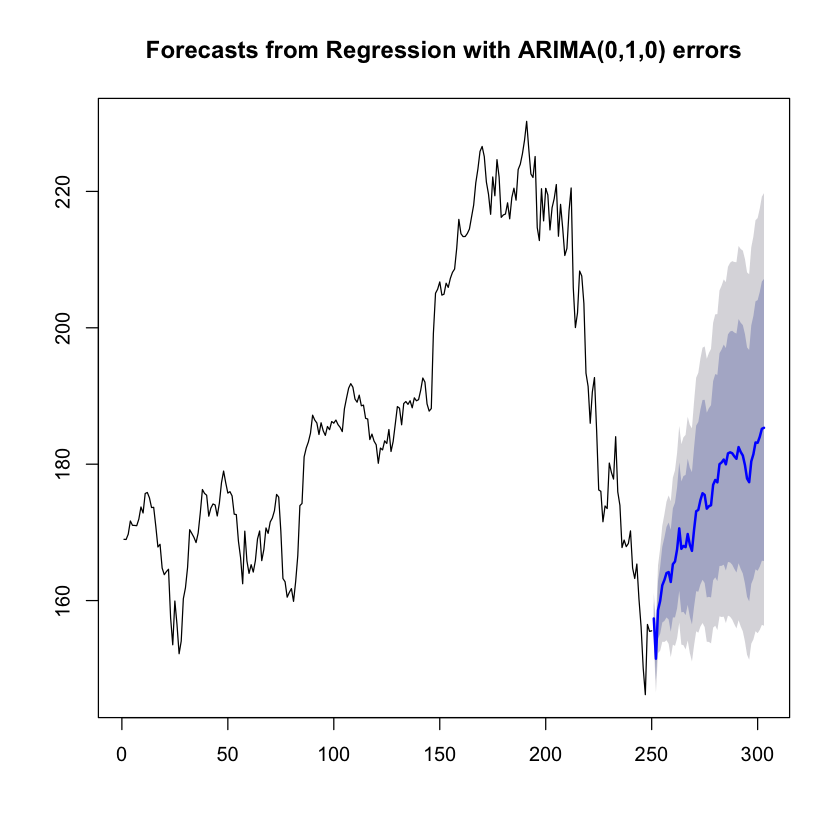

In [304]:
plot(fcast_AAPL)

In [307]:
#example: testing Nike, with forecasts in 2019 only
#market1018 <- tq_get("SPY", from = '2010-01-01', to = '2018-12-31')
#market19 <- tq_get("SPY",from= '2019-01-01',to='2019-03-15')
fcast_NKE <- make_ARIMA_forecast('NKE',sp2018,market18, sp2019, market19)
summary(fcast_NKE)


Forecast method: Regression with ARIMA(0,1,0) errors

Model Information:
Series: price 
Regression with ARIMA(0,1,0) errors 
Box Cox transformation: lambda= 0 

Coefficients:


Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”

      xreg1   xreg2   xreg3
      2e-04  -1e-04  0.0392
s.e.  0e+00   1e-04     NaN

sigma^2 estimated as 0.0001805:  log likelihood=721.39
AIC=-1434.78   AICc=-1434.62   BIC=-1420.71

Error measures:
                    ME      RMSE      MAE        MPE     MAPE      MASE
Training set 0.0617066 0.9685835 0.692289 0.08125369 0.957202 0.7673281
                  ACF1
Training set -0.184903

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95     Hi 95
251       74.02368 72.76012 75.30919 72.09998  75.99870
252       72.39223 70.65087 74.17651 69.74606  75.13879
253       74.72579 72.53031 76.98774 71.39432  78.21272
254       75.51674 72.96065 78.16238 71.64275  79.60022
255       76.30177 73.42009 79.29656 71.93895  80.92919
256       76.66576 73.49976 79.96813 71.87706  81.77350
257       77.24198 73.80238 80.84188 72.04401  82.81498
258       77.31634 73.64145 81.17461 71.76733  83.29439
259       76.24785 72.40954 80.28962 70.45650  82.51523
260       77.13297 73.04573 81.44891 

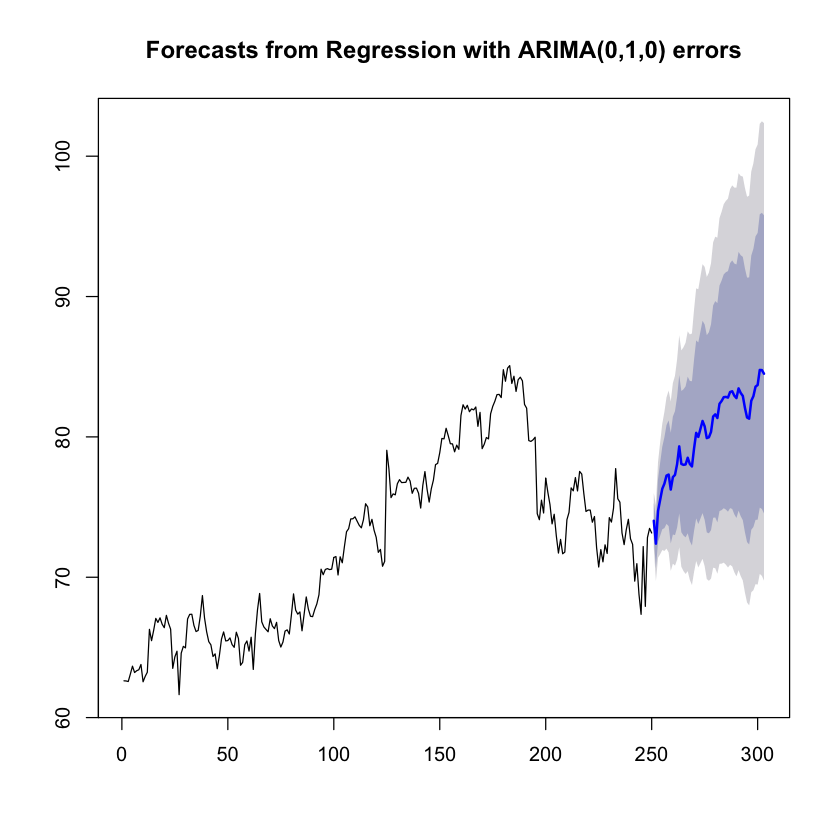

In [308]:
plot(fcast_NKE)

## Modeling the Variance
#### EGARCH/GARCH-MIDAS
Starting with 1-component eGARCH model, which is somewhat similar to GARCH-MIDAS. Going to transition to GARCH-MIDAS, which is a variant on the traditional econometric GARCH(1,1)/occasional GARCH(2,2) model in which there is a component modeling short-term volatility, and one for longer-term volatility

In [313]:
ARIMA_order <- function(arima_mod){
    armals <- arima_mod$arma
    d <- arima_mod$arma[length(arima_mod$arma)-1]
    ar <-arima_mod$arma[1]
    ma <- arima_mod$arma[2]
    order <- c(ar,d,ma)
    return(order)
}

In [323]:
#exog must be a matrix!
EGARCH_fit <-function(arima_model, log_returns, exog){
    
    arima_order <- ARIMA_order(arima_model)

    model_specs <- ugarchspec(variance.model = list(model = "eGARCH", garchOrder = c(1, 1), 
    submodel = NULL, external.regressors = NULL, variance.targeting = TRUE), 
    mean.model = list(armaOrder = c(arima_order[0], arima_order[3]), include.mean = TRUE, archm = TRUE, 
    archpow = 1, arfima = FALSE, external.regressors = exog))
    
    fit_model <-tryCatch(
        ugarchfit(model_specs, log_returns, solver = 'hybrid'),
        error=function(e) e, warning=function(w) w)
    
    return(fit_model)
}
EGARCH_fitted_series <- function(egarch_model){
    return(fitted(egarch_model))
}

In [315]:
exg <- make_ARIMA_exog('AAPL', sp1018, market1018)
#diff_market_ret <- diff(exg[,3])
#print(diff_market_ret)
#newexg <- exg[1:length(diff_market_ret),]
#print(dim(newexg))
#newexg[,3] <- diff_market_ret
amod <- make_ARIMAX('AAPL',sp1018,market1018)
ams <- ugarchspec(variance.model = list(model = "eGARCH", garchOrder = c(1, 1), 
    submodel = NULL, external.regressors = NULL, variance.targeting = TRUE), 
    mean.model = list(armaOrder = ARIMA_order(amod), include.mean = TRUE, archm = FALSE, 
    archpow = 1, arfima = FALSE, external.regressors = exg))
afit_model <-tryCatch(
        ugarchfit(ams, make_ARIMA_price('AAPL', sp1018), solver = 'hybrid'),
        error=function(e) e, warning=function(w) w)
#appl_egmod_spec <-  EGARCH_fit(amod, ts(resid(amod)), exg)
afit_model #it'll say the AIC is 3.5395, but it's actually (2k-2LogLik) = 7997.6


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
         Estimate  Std. Error    t value Pr(>|t|)
mu     -56.089088    0.159970 -350.62193 0.000000
ma1      0.868301    0.008590  101.07952 0.000000
mxreg1  -0.000972    0.001023   -0.95031 0.341956
mxreg2   0.027946    0.006397    4.36827 0.000013
mxreg3   8.529915    0.012875  662.49555 0.000000
alpha1   0.017518    0.016373    1.06988 0.284673
beta1    0.976674    0.006434  151.79065 0.000000
gamma1   0.721609    0.059523   12.12318 0.000000
omega    0.087746          NA         NA       NA

Robust Standard Errors:
         Estimate  Std. Error    t value Pr(>|t|)
mu     -56.089088    0.317903 -176.43480 0.000000
ma1      0.868301    0.014049   61.80454 0.000000
mxreg1  -0.00097

## A Better Variance Model
https://www.sciencedirect.com/science/article/abs/pii/S1544612318308067

Or also a GAS model instead of the immediate GARCH family.

In [316]:
make_GAS_model <- function(arimax_model){
    GAS_spec <- UniGASSpec(Dist = "ast", ScalingType="Identity",
                 GASPar = list(location = FALSE, scale = TRUE,skewness = TRUE, shape = TRUE,shape2 = TRUE))
    model <- UniGASFit(GAS_spec, (10^(3))*resid(arimax_model))
    return(model)
}


In [318]:
market1018 <- tq_get("SPY", from = '2010-01-01', to = '2018-12-31')
market19 <- tq_get("SPY",from= '2019-01-01',to='2019-03-15')
mm_NKE <- make_ARIMAX('NKE',sp1018,market1018)
summary(mm_NKE)

Series: price 
Regression with ARIMA(0,1,0) errors 
Box Cox transformation: lambda= 0 

Coefficients:
      xreg1   xreg2   xreg3
          0  -2e-04  0.0517
s.e.      0   1e-04  0.0000

sigma^2 estimated as 0.0001574:  log likelihood=6695.4
AIC=-13382.81   AICc=-13382.79   BIC=-13359.91

Training set error measures:
                     ME      RMSE       MAE        MPE      MAPE      MASE
Training set 0.01407049 0.5659319 0.3284553 0.03691755 0.8206757 0.8031891
                    ACF1
Training set -0.08640618


In [319]:
NKE_GAS_spec <- UniGASSpec(Dist = "ast", ScalingType="Identity",
                 GASPar = list(location = FALSE, scale = TRUE,skewness = TRUE, shape = TRUE,shape2 = TRUE))
NKE_model <- UniGASFit(NKE_GAS_spec, (10^(3))*resid(mm_NKE))
NKE_model


------------------------------------------
-          Univariate GAS Fit            -
------------------------------------------

Model Specification:	
T =  2263
Conditional distribution:  ast
Score scaling type:  Identity
Time varying parameters:  scale, skewness, shape, shape2
------------------------------------------
Estimates:
            Estimate   Std. Error       t value     Pr(>|t|)
kappa1  3.323318e-01 3.706868e-01  8.965300e-01 1.849849e-01
kappa2  3.253029e-02 2.027311e-02  1.604603e+00 5.429058e-02
kappa3 -3.136473e-03 1.354438e-02 -2.315701e-01 4.084360e-01
kappa4 -3.456290e-01 2.317111e-06 -1.491637e+05 0.000000e+00
kappa5 -4.657787e+00 8.717250e-07 -5.343184e+06 0.000000e+00
a2      2.455331e-02 6.043837e-03  4.062536e+00 2.427119e-05
a3      1.424591e-05 1.156085e-10  1.232255e+05 0.000000e+00
a4      5.499492e+00 2.870310e-08  1.915992e+08 0.000000e+00
a5      1.897475e-01 0.000000e+00           Inf 0.000000e+00
b2      9.892858e-01 6.647256e-03  1.488262e+02 0.00000

In [320]:
NKE_GAS_fcast <- UniGASFor(NKE_model, H = 20)
NKE_GAS_fcast


------------------------------------------
-        Univariate GAS Forecast         -
------------------------------------------

Model Specification
Conditional distribution:  ast
Score scaling type:  Identity
Horizon:  20
Rolling forecast:  FALSE
------------------------------------------
Parameters forecast:
     location    scale  skewness    shape   shape2
T+1 0.3323318 28.01330 0.4967261 4.000000 4.000000
T+2 0.3323318 27.99105 0.4973144 4.000000 4.000006
T+3 0.3323318 27.89491 0.4977645 4.000001 4.000090
T+4 0.3323318 27.88177 0.4981090 4.000001 4.000694
T+5 0.3323318 27.83159 0.4983725 4.000001 4.003269

....................
      location    scale  skewness    shape   shape2
T+16 0.3323318 27.49560 0.4991862 4.000025 4.339911
T+17 0.3323318 27.51343 0.4991967 4.000032 4.359319
T+18 0.3323318 27.50180 0.4992049 4.000041 4.374786
T+19 0.3323318 27.45460 0.4992110 4.000053 4.386845
T+20 0.3323318 27.47249 0.4992159 4.000067 4.396223

refs:
https://www.sciencedirect.com/science/article/pii/S037842661830181X